# BIOMASS PRODUCT COMPARISON : COUNTRY SUMMARY FOR GHANA ### 

##### CODE PREPARED BY: 

##### Neha Hunka, University of Maryland 
##### Veronika Leitold, University of Maryland
##### David Minor, University of Maryland

### LOAD PACKAGES

In [ ]:
packages <- c("terra", "sf", "rgeos", "geosphere","RColorBrewer","jpeg","plyr","maptools", "scales")
package.check <- lapply(packages, FUN = function(x) {
    if (!require(x, character.only = TRUE)) {
        install.packages(x, dependencies = TRUE)
        library(x, character.only = TRUE, quietly=TRUE)
    }
})
Sys.setenv("AWS_DEFAULT_REGION" = 'us-west-2')

#### LINK TO PRE-DEFINED FUNCTIONS ###

In [2]:
source_link <-'/projects/ADE_biomass_harmonization/biomass_harmonization/NASA_CMS_2023/Ghana/Country_summaries_functions.R'
source(source_link)

#### LIST OF AVAILABLE COUNTRY BOUNDARIES ###

In [ ]:
Cont <- st_read("/projects/my-public-bucket/Data/Country_boundaries/GEDI_countries_Dubayah_etal2022.shp")
Country_list <- cbind(data.frame(Cont$ne_10m_adm), data.frame(Cont$ne_10m_a_1), data.frame(Cont$ne_10m_a_2), data.frame(Cont$Evaluate), data.frame(Cont$Eval_ISB))
colnames(Country_list) <- c('Country',"CODE", "Continent","Evaluate","Eval_ISB")

### BIG COUNTRIES SPLIT #######
BIG_countries <- FALSE

### Set the country code for which biomass comparison is to be done (if unsure, see above list) 

In [4]:
iso3 <- c("GHA") 

In [ ]:
Base_folder = '/projects/my-public-bucket/Data/NASA_CMS_2023/GHANA/' 

################# Create necessary subfolders for outputs #####################################
if (!dir.exists(Base_folder)){dir.create(Base_folder)}
Out_folder = file.path(Base_folder,iso3)
if (!dir.exists(Out_folder)){dir.create(Out_folder)}
if (dir.exists(Out_folder)){dir.create(file.path(Out_folder,paste0(iso3,'_Product_Comparisons')))}
if (dir.exists(Out_folder)){dir.create(file.path(Out_folder,paste0(iso3,'_Product_AOI')))}
if (dir.exists(Out_folder)){dir.create(file.path(Out_folder,paste0(iso3,'_Product_FMASK')))}

### Set the maps that need to be compared and the versions/date

In [6]:
maps <- c('CCI','GEDI','NCEO') # List the maps for which a comparison is to be done ,'NCEO','JPL'

################# Exception if country not in Africa ########################################
if (is.element('NCEO', maps) & !Country_list$Continent[Country_list$CODE == iso3] == 'Africa'){
    print('NOTE : Country is not in Africa - NCEO will be removed') 
    maps = maps[maps != 'NCEO']
    } 
if (Country_list$Eval_ISB[Country_list$CODE == iso3] == 'N') {maps = maps[maps != 'ISB']}
if (is.element('ISB', maps) & dir.exists(Out_folder)){
    dir.create(file.path(Out_folder,paste0(iso3,'_Product_ISB')))
    isb_folder <- file.path(Out_folder,paste0(iso3,'_Product_ISB'))
}

### Set the years and versions of the biomass maps to be used 

In [7]:
if (is.element('CCI', maps)){CCI_year = '2020'
                             CCI_version = 4}
if (is.element('GEDI', maps)){GEDI_year = '2020'}
if (is.element('NCEO', maps)){NCEO_year = '2017'}

### Set source folders of biomass maps

In [8]:
# if (is.element('CCI', maps)){cci_folder <- paste0("/projects/my-public-bucket/Data/Biomass_maps/CCI_2018/dap.ceda.ac.uk/neodc/esacci/biomass/data/agb/maps/v3.0/geotiff")}
if (is.element('CCI', maps)){cci_folder <- paste0('/projects/my-private-bucket/Data/CCI_2020')}
if (is.element('GEDI', maps)){gedi_folder <- "/projects/my-public-bucket/Data/Biomass_maps/GEDI_L4B_v21"}
if (is.element('NCEO', maps)){nceo_folder <- "/projects/shared-buckets/minord/data/nceo_africa_biomass/clipped"}

##### Set how forest/non-forest areas should be treated 
#####  - (External = An external datasource (e.g. Hansen, ALOS, Sentinel, or country-provided map) is used to mask out pixels in all maps)
#####  - (None = no forest mask is applied, maps are treated just as they are provided)

In [9]:
forest_mask <- c('None') # c('External') or c('None') 
if (forest_mask == c('None')) {Default_FMASK = FALSE}
if (forest_mask == c('External')) {
    Default_FMASK = TRUE #set to true if no external mask is available. Default uses 2020 Hansen Tree Cover in units of %. 
    if (Default_FMASK){
        print("Hansen 2020 tree cover % to be used as an FMASK")
        EMask_folder <- "/projects/shared-buckets/leitoldv/gfc_data" # Source folder for original Hansen 2020 TC maps 
        HOut_folder <- "/projects/my-public-bucket/Biomass_Harmonization_OUTPUTS/HANSEN_TC2020" # Output folder for processed Hansen 2020 TC maps 
        if (!dir.exists(HOut_folder)){dir.create(HOut_folder)}
        EMask_file <- paste0("HANSEN_TC2020_",iso3,".tif") # Name of output file for Hansen 2020 TC map for country of interest  
        non_forest_value <- 10
        resample_method <- "bilinear" 
    }
    if (!Default_FMASK){
        print("External FMASK is provided by user")
        print(paste("Please refer to",source_link,"to adjust for parameters of the countr-specific forest mask"))
    }
}

### GENERATE A GRID FOR CCI AND HANSEN LAYERS (do not remove even if CCI and HANSEN are not used)  

In [ ]:
comparison_grid <- c('CCI')
Grid_tiles <- Grid_set(maps=comparison_grid)

### DISPLAY COUNTRY OF INTEREST AND TILES 

Warning message in plot.sf(aoi, col = "red", add = T):
“ignoring all but the first attribute”


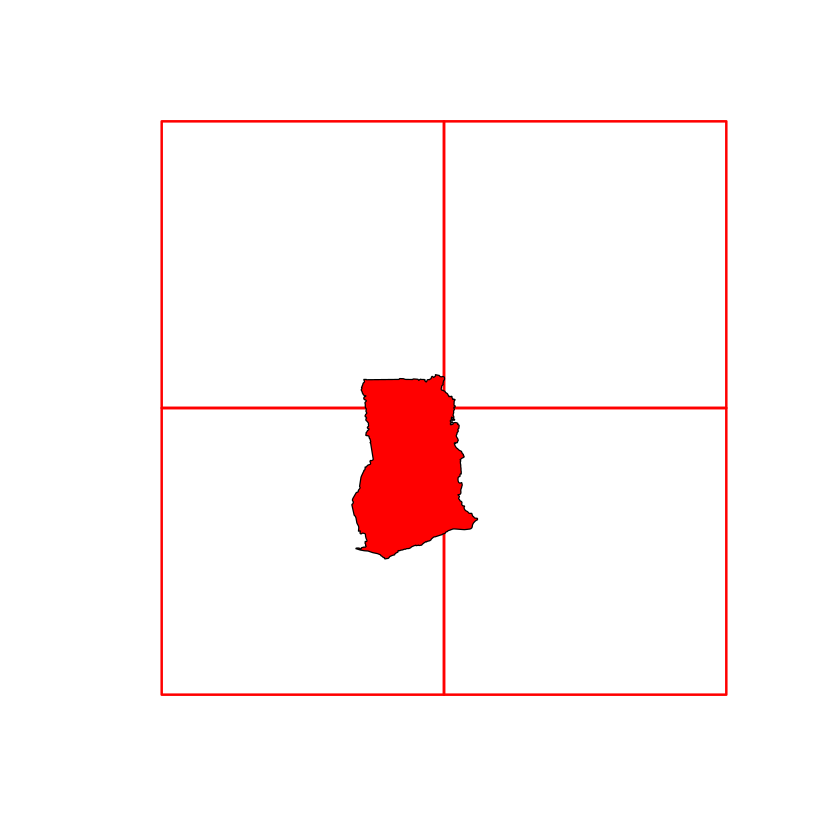

In [12]:
# Cont <- Cont[Cont$CONTINENT==Country_list$Continent[Country_list$CODE == iso3],]
Cont$ADM0_A3 <- Country_list$CODE
conti <- Country_list$Continent[Country_list$CODE == iso3]
if (conti=="South America"){conti = "SAmerica"}
if (conti=="North America"){conti = "NAmerica"}
if (conti=="Seven seas (open ocean)" & (iso3=="MDV" | iso3=='MUS' | iso3=='SYC')){conti = "Africa"}
if (conti=="Asia" & (iso3=="TLS" | iso3=='MUS' | iso3=='SYC')){conti = "Oceania"}
aoi <- Cont[Cont$ADM0_A3 == iso3,]
AOI_file = file.path(Out_folder,paste0(iso3,'_aoi.shp'))
if (!file.exists(AOI_file)) {st_write(obj=aoi, dsn=Out_folder, layer=paste0(iso3,'_aoi'), driver="ESRI Shapefile")}
if (!identical(st_crs(aoi), st_crs(Grid_tiles))){aoi <- aoi %>% st_transform(st_crs(Grid_tiles))}

intersecting <- (st_intersects(st_as_sf(aoi),st_as_sf(Grid_tiles)))[[1]]
nrow_tiles <- intersecting
if (length(intersecting) == 0) {
    stop('no intersecting CCI Biomass tiles found')
} else {tiles <- (Grid_tiles[nrow_tiles,])}

aoi <- aoi %>% st_transform(st_crs(tiles)) # Transform aoi to match tiles CRS so it can be used later for cropping
plot(tiles, lwd=2, border="red")
plot(aoi, col="red", add=T)

### READ BIOMASS MAPS, PREPARE AOI_MASKED DATA AND PLOTS

##### (original maps and histograms, no resampling done here!)

Warning message in plot.sf(aoi, add = T, col = NA, border = "black"):
“ignoring all but the first attribute”
Warning message in plot.sf(aoi, add = T, col = NA, border = "black"):
“ignoring all but the first attribute”
Warning message in plot.sf(aoi, add = T, col = NA, border = "black"):
“ignoring all but the first attribute”


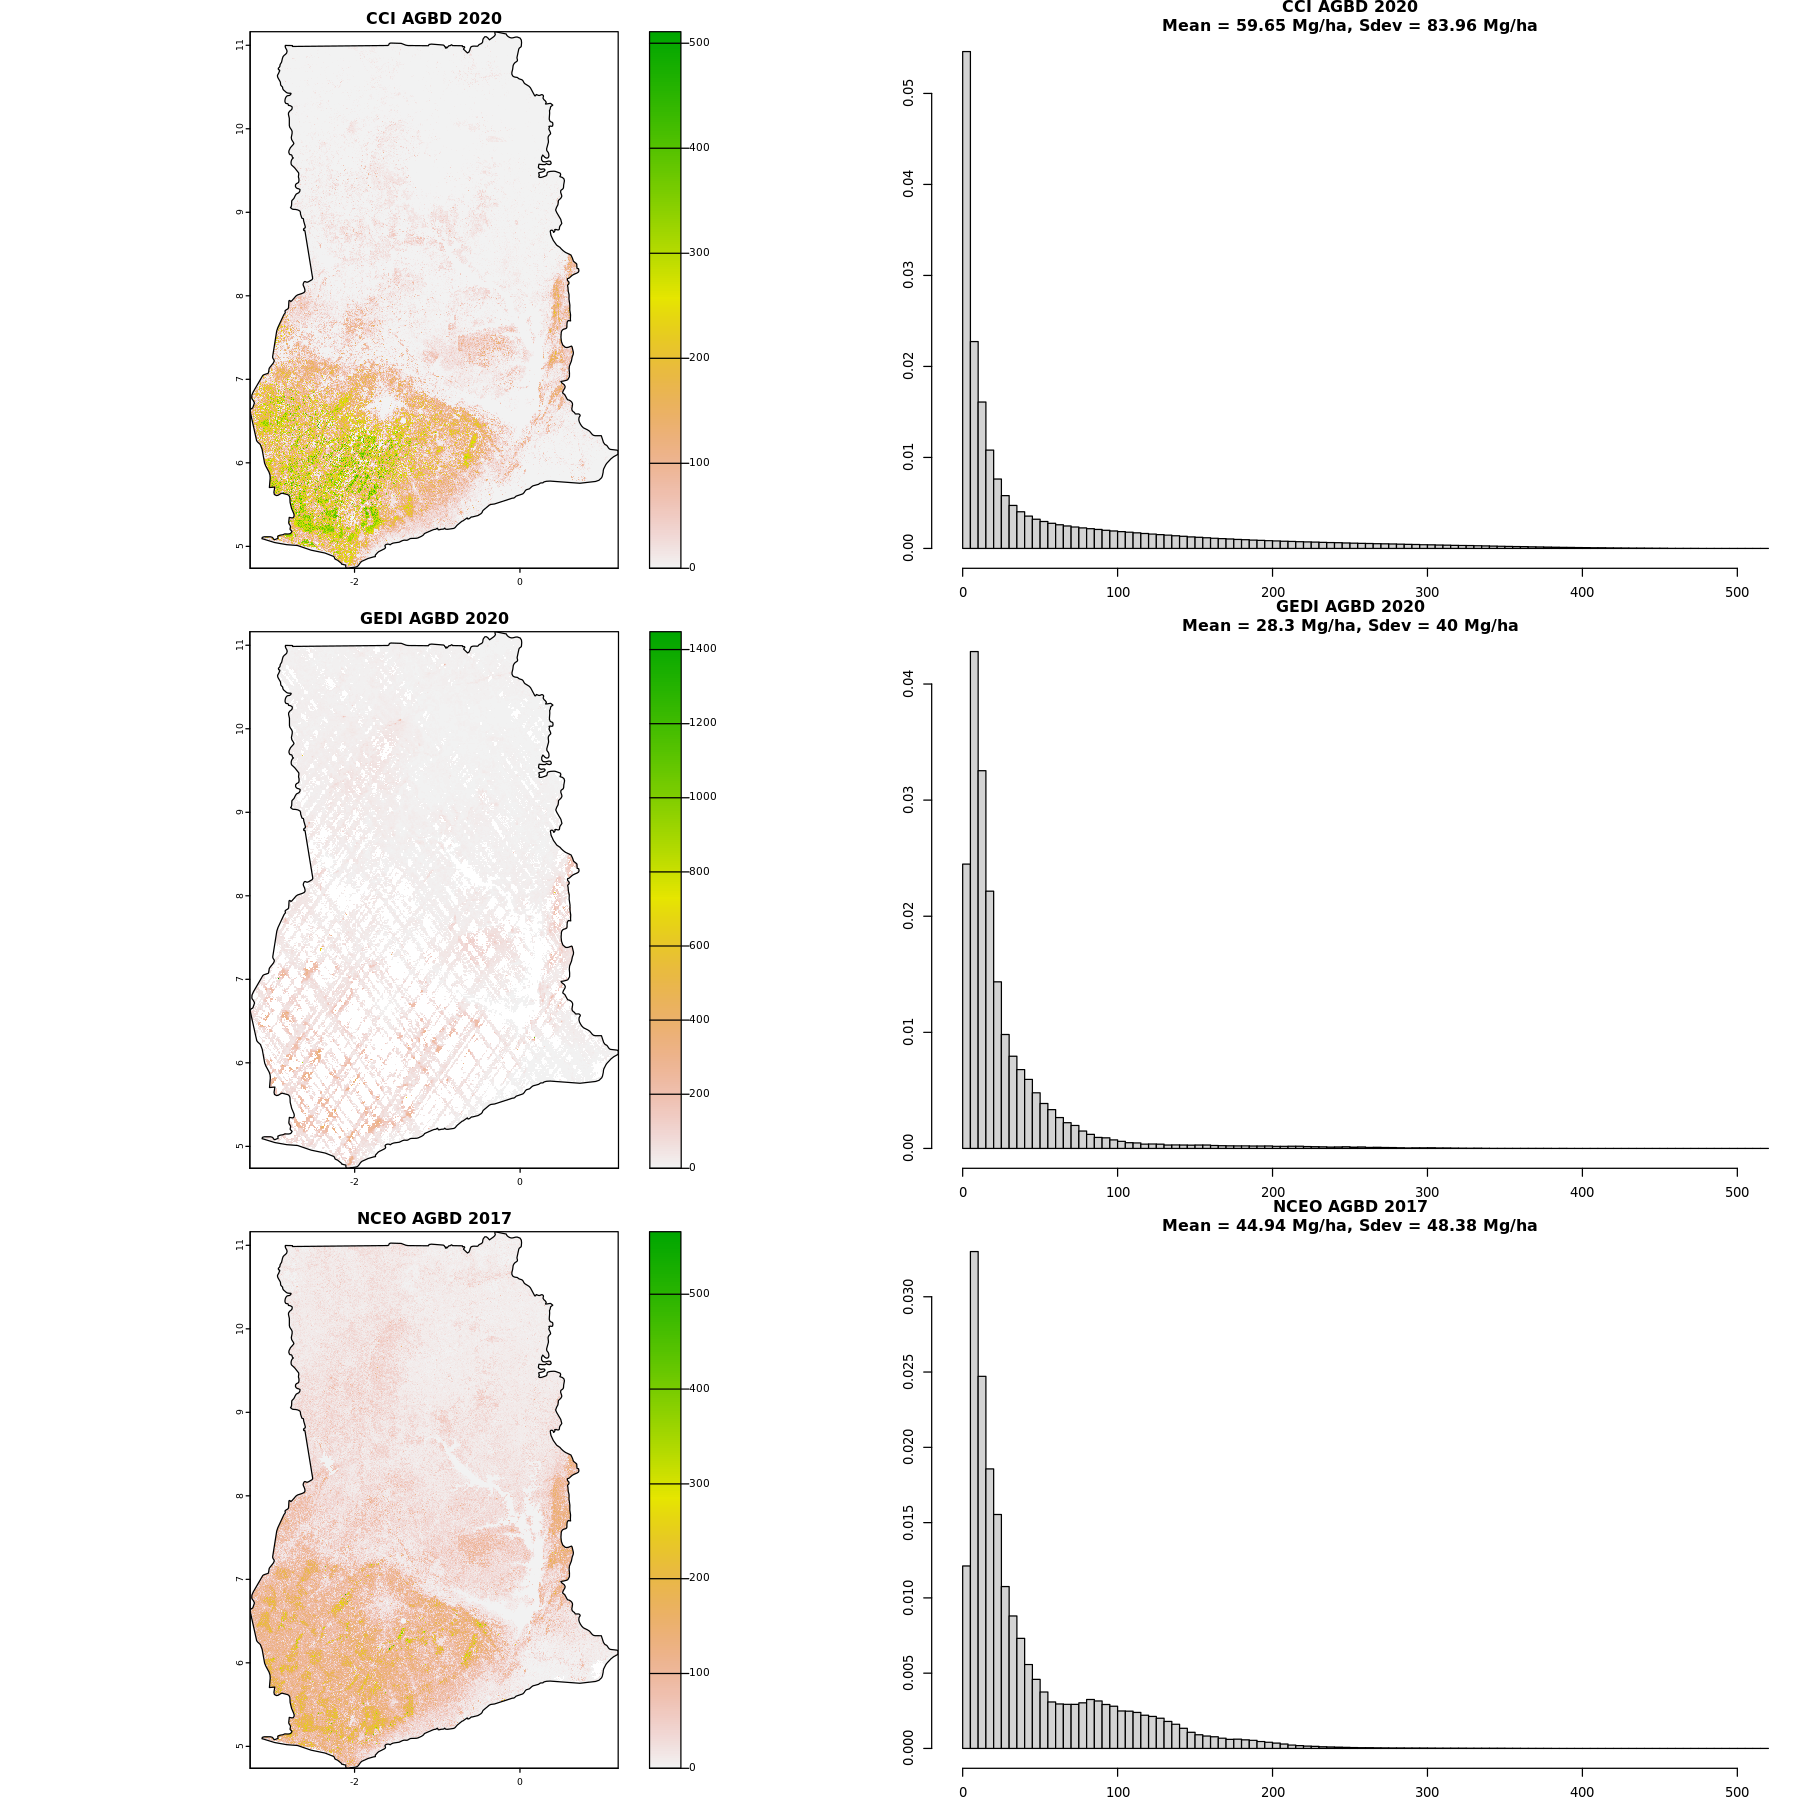

In [14]:
Link_maps_AOImasked <- ''
maps_AOImasked <- ''
for (i in 1:length(maps)){
    print(maps[i])
    assign((text = tolower(maps[i])),readAGBmap(AOI_file=AOI_file,aoi=aoi,continent=conti,map=maps[i],In_folder=eval(parse(text=paste0(tolower(maps[i]),'_folder'))),In_year = eval(parse(text=paste0(maps[i],'_year'))),cci_version=CCI_version,Out_folder=Out_folder))
    maps_AOImasked[[length(maps_AOImasked) + 1]] <- paste0(tolower(maps[i]),"_AOImasked")
    Link_maps_AOImasked[[length(Link_maps_AOImasked) + 1]] <- file.path(Out_folder,paste0(iso3,'_Product_AOI'),paste0(maps[i],"_AOImasked.tif"))
    assign((text = paste0(tolower(maps[i]),"_AOImasked")),(mask(eval(parse(text=tolower(maps[i]))), aoi, updatevalue=NA)))

    corrected_values <- eval(parse(text=paste0(tolower(maps[i]),"_AOImasked")))
    corrected_values[corrected_values<0]=0
    assign((text = paste0(tolower(maps[i]),"_AOImasked")),corrected_values)
    assign((names(eval(parse(text=paste0(tolower(maps[i]),"_AOImasked"))))), c(paste0("agbd_",paste0(maps[i],"_year"))))
    writeRaster(eval(parse(text=paste0(tolower(maps[i]),"_AOImasked"))),file.path(Out_folder,paste0(iso3,'_Product_AOI'),paste0(maps[i],"_AOImasked.tif")), overwrite=TRUE)
    rm(list = c("corrected_values"))
    rm(list = c(tolower(maps[i])))
}
maps_AOImasked <- maps_AOImasked[maps_AOImasked != ""]
Link_maps_AOImasked <- Link_maps_AOImasked[Link_maps_AOImasked != ""]

par(mfrow=c(length(maps),2), mar=c(2,2,2,2))
options(repr.plot.width=15, repr.plot.height=15)
Save_Perc999 <- Percentile_xlim(maps=maps) 
for (i in 1:length(maps)){
    plot(eval(parse(text=paste0(tolower(maps[i]),"_AOImasked"))), main=paste0(maps[i]," AGBD ", eval(parse(text=paste0(maps[i],"_year")))), zlim=c(0,Save_Perc999),cex.lab=2, cex.axis=2)
    plot(aoi, add=T,col=NA,border="black")
    map_values <- values(eval(parse(text=paste0(tolower(maps[i]),"_AOImasked"))))
    map_values <- map_values[map_values > 0]
    assign((text = paste0(tolower(maps[i]),"_AOImeans")),round(mean(map_values, na.rm=TRUE),2))
    for_n_count <- eval(parse(text=paste0(tolower(maps[i]),"_AOImasked")))
    if (BIG_countries == TRUE) {assign((text = paste0(tolower(maps[i]),"_AOImeans_ncount")),length(for_n_count[for_n_count>0]))}
    if (!all(is.na(map_values))) {
        hist(map_values, freq=F,breaks=seq(0,round(max(map_values,na.rm=T),digits=-1)+5,5),main=paste0(maps[i]," AGBD ", eval(parse(text=paste0(maps[i],"_year"))),'\n',paste("Mean = ",round(mean(map_values, na.rm=TRUE),2),sep=""),paste(" Mg/ha, Sdev = ",round(sd(map_values, na.rm=TRUE),2)," Mg/ha",sep="")),cex.lab=1, cex.axis=1, xlab="Aboveground biomass [Mg/Ha]", xlim=c(0,Save_Perc999+50))#, ylim=c(0,0.025)
    } else {plot(NULL, xlim=c(0,1), ylim=c(0,1), ylab="y label", xlab="x lablel",main=paste0(maps[i]," AGBD ", eval(parse(text=paste0(maps[i],"_year"))),": No values"))}
    rm(list = c("map_values","for_n_count"))
}